In [1]:
import feets.preprocess
from scipy import stats
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import feets
from ipykernel import kernelapp as app
import os



script_dir = os.path.dirname('Results/')
results_dir = os.path.join(script_dir, 'Images/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

In [2]:
url = "https://raw.githubusercontent.com/MachineLearningUniandes/MANTRA/master/data/lightcurves/transient_lightcurves.csv"
url1 = 'https://raw.githubusercontent.com/MachineLearningUniandes/MANTRA/master/data/lightcurves/transient_labels.csv'
url2 = 'https://raw.githubusercontent.com/MachineLearningUniandes/MANTRA/master/data/lightcurves/transient_info.txt'
transient_lc = pd.read_csv(url)
transient_labels = pd.read_csv(url1)
transient_info = pd.read_table(url2,skiprows=1,names=['CRTS_ID' ,'RA' ,'Dec','UT_Date','Mag','CSS_images' ,'SDSS',
                                                      'Others' ,'Followed' ,'Last','LC','FC','Classification'])

transient_info.head()


,CRTS_ID,RA,Dec,UT_Date,Mag,CSS_images,SDSS,Others,Followed,Last,LC,FC,Classification
0,CSS120828:000010-215515,0.04323,-21.92087,20120828.38,17.02,1208280210014111715,no,11171,no,2016-10-22,11171,yes,Var
1,CSS100910:000025+332543,0.10280,33.42861,20100910.42,15.85,1009101320014148188,yes,14818,no,2016-11-05,14818,yes,"CV SDSS mag 20,5"
2,CSS101127:000130+050624,0.37695,5.10657,20101127.21,15.68,1011271040014129121,no,12912,yes,2016-11-06,12912,yes,"CV mag 20,0"
3,CSS160709:000132+211336,0.38474,21.22680,20160709.45,17.21,1607091210014124380,yes,12438,no,2016-11-05,12438,yes,Blazar CRATES_J0001+2113
4,CSS110926:000156+065236,0.48205,6.87665,20110926.30,19.35,1109261070014122864,no,12286,yes,2016-11-06,12286,yes,"SN 2011hl SDSS mag 15,7 2MASX_00015920"


In [3]:
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [9]:
# Reading in the feature.csv data
ft_data = pd.read_csv('features.csv',skiprows=1,names= ['Amplitude', 'AndersonDarling', 'Autocor_length', 'Beyond1Std',
                                                  'CAR_sigma', 'Con', 'Eta_e', 'Freq1_harmonics_rel_phase_1',
                                                  'LinearTrend', 'MaxSlope', 'Mean', 'Period_fit', 
                                                  'SlottedA_length','SmallKurtosis', 'StructureFunction_index_21'
                                                  ,'ID','Class'])


ft_data.head()

,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,CAR_sigma,Con,Eta_e,Freq1_harmonics_rel_phase_1,LinearTrend,MaxSlope,Mean,Period_fit,SlottedA_length,SmallKurtosis,StructureFunction_index_21,ID,Class
0,1.50475,1.000000,2.0,0.411765,10.0,0.015152,1.639083e+07,0.133163,-0.000216,310.686183,20.125262,1.000000,6.0,10.438348,1.742156,TranID1209210010044118805,Flare
1,1.53220,1.000000,8.0,0.345946,10.0,0.032787,2.411989e+06,-0.209898,-0.000333,317.453004,19.331475,0.000000,1.0,3.227174,1.723731,TranID1310250040014131234,SN
2,1.24740,0.999302,2.0,0.414634,10.0,0.000000,8.020303e+06,1.009082,0.000009,123.993913,20.123456,0.970337,17.0,0.000310,1.731060,TranID1011080040044131101,SN
3,1.23785,1.000000,6.0,0.410000,10.0,0.061224,4.823456e+06,-0.119399,-0.000227,146.497039,19.704732,0.003795,2.0,1.244926,1.677341,TranID1310250070034110542,SN
4,1.36500,1.000000,30.0,0.371528,10.0,0.073427,2.173539e+05,0.397704,-0.000552,210.703834,18.261774,0.000000,3.0,1.919426,1.403380,TranID1201030070034134767,Blazar


In [10]:
params = ['Amplitude', 'AndersonDarling', 'Autocor_length', 'Beyond1Std',
                                                  'CAR_sigma', 'Con', 'Eta_e', 'Freq1_harmonics_rel_phase_1',
                                                  'LinearTrend', 'MaxSlope', 'Mean', 
                                                  'SlottedA_length','SmallKurtosis', 'StructureFunction_index_21'
                                                  ]

X = ft_data[params]

In [11]:
model=IsolationForest(n_estimators=400, max_samples='auto',max_features=1.0)
x=model.fit(X)



pred_cls = []
# Predicting the anomalies
ft_data['iforest'] = pd.Series(model.predict(X))
ft_data['iforest_Counts'] = ft_data['iforest'].map({1:0,-1:1})
# Counting the detected anomalies
print(ft_data['iforest'].value_counts())

# Analysing the predicted anomalies
pred=ft_data.loc[ft_data['iforest'] == -1]
for i in range(len(pred.ID)):
    
    
#     plt.figure(figsize=(16,4))
#     plt.xlabel('MJD')
#     plt.ylabel('Mag')
    lc = transient_lc[transient_lc['ID']==pred.ID.iloc[i]]
    
#     print(len(lc),pred.Class.iloc[i],pred.ID.iloc[i])
    pred_cls.append(pred.Class.iloc[i])
#     plt.errorbar(lc.MJD,lc.Mag,yerr=lc.Magerr,fmt='.r',label=pred.Class.iloc[i])
#     plt.legend()
#     plt.show()

 1    2418
-1      88
Name: iforest, dtype: int64


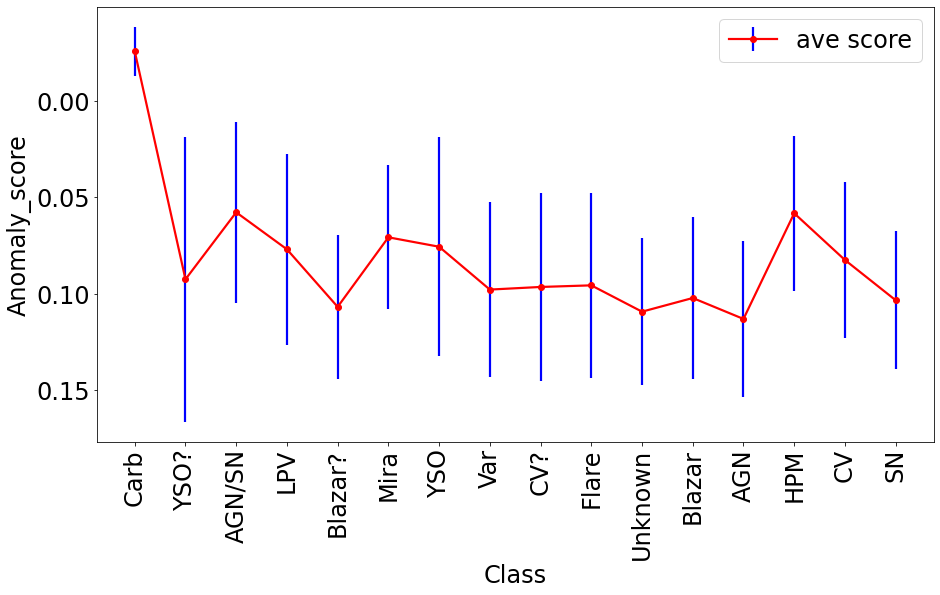

In [12]:
sklearn_score_anomalies = model.decision_function(X)

# print(sklearn_score_anomalies)

x = [i  for i in sklearn_score_anomalies]

# len(ft_data[x])

anomalies_scr=sklearn_score_anomalies
anomalies_cls = ft_data.Class


# Getting the unique classes detected as anomalous
ML_unq_cls=np.unique(pred_cls)
# x = [i < 0 for i in sklearn_score_anomalies]
# anomalies_scr=sklearn_score_anomalies[x]
# anomalies_cls = ft_data.Class[x]
# anomalies_ID = ft_data.ID[x]

# Getting the number of objects in each anomalous class 
# based on the transient label data
len_anm = []
for i in ML_unq_cls:
    
    lb = transient_labels[transient_labels['Classification']==i]   
    len_anm.append(len(lb))


# Sorting the classes in ascending based on the number of
# objects in each class (i.e most anomalous to least anomalous)
cls = []  
for i in range(0,max(len_anm)+1): 
    
    for j in range(len(len_anm)): 
        
        if len_anm[j] == i: 
            cls.append(ML_unq_cls[j])
            
                        
# Calculating the average and std of the anom
# scores

sstd,aave = [],[] ; catgories = []; scr1=[]
for j in range(len(cls)):
    scr = []
    for i in range(len(anomalies_cls)):
    
        if anomalies_cls.iloc[i] == cls[j]:
            
            scr.append(anomalies_scr[i])
            scr1.append(anomalies_scr[i])
            
    catgories.append(scr)
            
#             print(anomalies_cls.iloc[i],anomalies_scr[i])
#     print(scr,np.std(scr))       
    std=np.std(scr)
    ave=np.average(scr)   
    sstd.append(std);aave.append(ave)
    
#     print(ave,std)
    
    

    
# Plotting the anomalous objects based on their score 
plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(15,8))
df = pd.DataFrame({"id":cls, 
                   "score":aave,
                   'error':sstd
                   })
plt.errorbar(np.arange(len(df['id'])), df['score'],yerr=df['error'],fmt='-ro',ecolor='b',label='ave score',linewidth=2.2)
ax = plt.gca()
ax.xaxis.set_ticks(np.arange(len(df['id'])))
ax.xaxis.set_ticklabels(df['id'], rotation=90)
plt.xlabel("Class")
plt.ylabel("Anomaly_score")
plt.gca().invert_yaxis()
plt.legend()
plt.savefig(results_dir + 'ave_score_all.png',bbox_inches="tight")
plt.show()

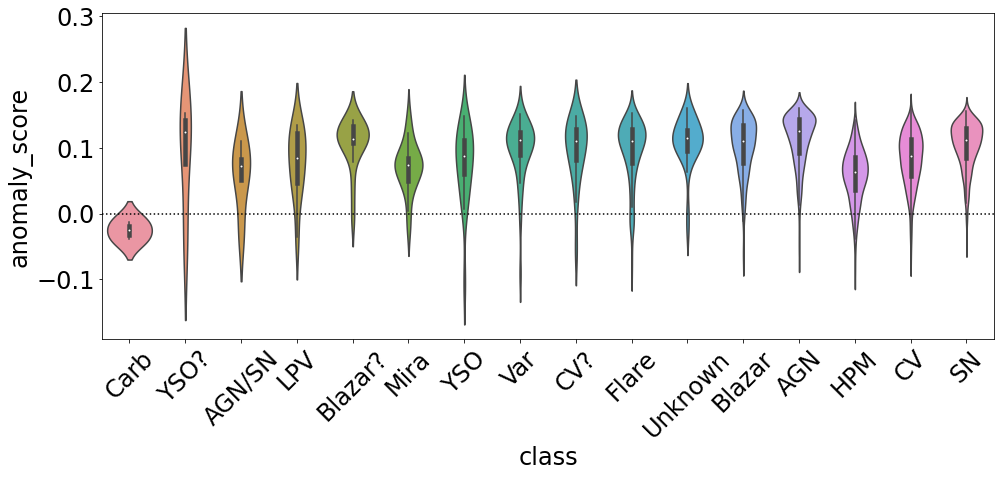

In [13]:
# import pandas as pd 
import pandas as pd 
  
# both lists, with columns specified 
df = pd.DataFrame(list(zip(anomalies_scr, anomalies_cls)), 
               columns =['anomaly_score', 'class']) 



plt.figure(figsize=(16,6))
x = sns.violinplot(x="class", y="anomaly_score", data=df,gridsize=200,order=cls,width=0.8)
plt.savefig('violin_plot.png')
# plt.xlabel('m')
plt.axhline(0,color='black',ls=':')
plt.xticks(rotation=45)
plt.show()

In [14]:
pred_cls

['Blazar',
 'CV',
 'Flare',
 'Flare',
 'Flare',
 'Carb',
 'HPM',
 'CV',
 'Unknown',
 'CV',
 'Flare',
 'Flare',
 'CV',
 'CV?',
 'Var',
 'Flare',
 'AGN',
 'Mira',
 'HPM',
 'YSO?',
 'LPV',
 'Var',
 'CV',
 'CV',
 'CV',
 'Flare',
 'AGN',
 'HPM',
 'CV',
 'Flare',
 'Flare',
 'CV',
 'Flare',
 'AGN',
 'SN',
 'CV',
 'HPM',
 'Blazar',
 'Blazar?',
 'CV',
 'SN',
 'CV',
 'Flare',
 'Blazar',
 'AGN',
 'HPM',
 'HPM',
 'Flare',
 'HPM',
 'AGN',
 'AGN',
 'Flare',
 'SN',
 'CV',
 'AGN',
 'HPM',
 'AGN/SN',
 'Blazar',
 'CV',
 'SN',
 'SN',
 'HPM',
 'Blazar',
 'CV',
 'Flare',
 'SN',
 'YSO',
 'CV',
 'SN',
 'CV',
 'CV',
 'CV',
 'CV',
 'Carb',
 'Flare',
 'CV',
 'HPM',
 'HPM',
 'HPM',
 'HPM',
 'HPM',
 'HPM',
 'HPM',
 'SN',
 'HPM',
 'HPM',
 'HPM',
 'HPM']